linear score
0.07957831235816049


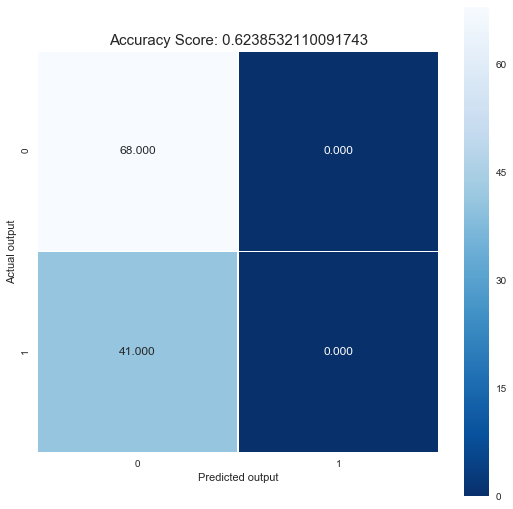

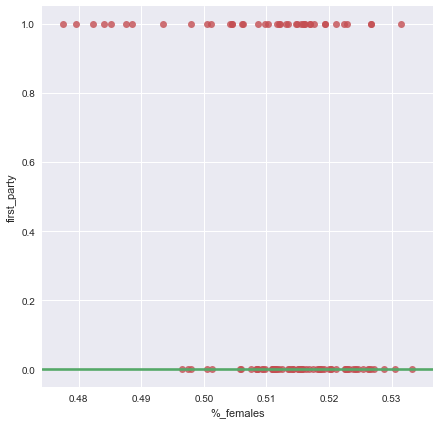

In [4]:
import pandas as pd
import numpy as np
import chardet

from IPython.display import clear_output
clear_output(wait=True)

results = pd.read_csv('constituency-results.csv')
results.drop(results.columns[[0,1,3,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]], axis=1, inplace=True)
results.rename(columns = {"constituency_name": "constituency"}, inplace = True)

sc_females = pd.read_csv('scotland-females.csv')
sc_females.rename(columns = {"UKPC Name": "constituency"}, inplace = True)
sc_females.drop(sc_females.columns[[0,2,3]], axis=1, inplace=True)
sc_females.drop(sc_females.columns[1:74], axis=1, inplace=True)

results = pd.merge(results, sc_females, how='left', on='constituency')
results.fillna(0,inplace=True)

with open('england-females.csv', 'rb') as f:
    result = chardet.detect(f.read())
en_females = pd.read_csv('england-females.csv', encoding=result['encoding'])
en_females.rename(columns = {"PCON11NM": "constituency"}, inplace = True)
en_females.drop(en_females.columns[1:75], axis=1, inplace=True)

results = pd.merge(results, en_females, how='left', on='constituency')
results.fillna(0,inplace=True)

results['females'] = results['females_x'] + results['females_y']
results.drop(results.columns[[4,5]], axis=1, inplace=True)

sc_males = pd.read_csv('scotland-males.csv')
sc_males.rename(columns = {"UKPC Name": "constituency"}, inplace = True)
sc_males.drop(sc_males.columns[[0,2,3]], axis=1, inplace=True)
sc_males.drop(sc_males.columns[1:74], axis=1, inplace=True)

results = pd.merge(results, sc_males, how='left', on='constituency')
results.fillna(0,inplace=True)

with open('england-males.csv', 'rb') as f:
    result = chardet.detect(f.read())
en_males = pd.read_csv('england-males.csv', encoding=result['encoding'])
en_males.rename(columns = {"PCON11NM": "constituency"}, inplace = True)
en_males.drop(en_males.columns[[0,2]], axis=1, inplace=True)
en_males.drop(en_males.columns[1:74], axis=1, inplace=True)

results = pd.merge(results, en_males, how='left', on='constituency')
results = results.fillna(0)

results['males'] = results['males_x'] + results['males_y']
results.drop(results.columns[[5,6]], axis=1, inplace=True)

results = results[results.males != 0]

results['population'] = results['females'] + results['males']
results['%_females'] = results['females']/results['population']
results.drop(results.columns[[0,1,2,4,5]], axis=1, inplace=True)

# Labour = 1, Other parties = 0
results['first_party'] = results['first_party'].map({'Lab': 1, 'Con': 0, 'SNP': 0, 'LD': 0, 'PC': 0})

results = results.fillna(0)

targets = results.iloc[:,0]
inputs = results.drop(results.columns[[0]], axis=1)


test_fraction = 0.2
p = [test_fraction, (1-test_fraction)]
train_part = np.random.choice([False, True], size=results.shape[0], p=p)
test_part = np.invert(train_part)

train_inputs = inputs.iloc[train_part, :]
train_targets = targets.iloc[train_part]

test_inputs = inputs.iloc[test_part, :]
test_targets = targets.iloc[test_part]

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# fitting model on training data
model.fit(train_inputs, train_targets)

# model score on test data
# fraction of correct predictions
score = model.score(test_inputs, test_targets)

predictions = model.predict(test_inputs)

from sklearn import metrics

cm = metrics.confusion_matrix(test_targets, predictions)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual output');
plt.xlabel('Predicted output');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

fig, ax = plt.subplots()
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7, 7)})
sns.regplot(x=test_inputs['%_females'], y=test_targets, fit_reg=False, ax=ax,scatter_kws={"color": "r"});
sns.regplot(x=test_inputs['%_females'], y=predictions,scatter=False, ax=ax, scatter_kws={"color": "g"});

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
loss = sigmoid(predictions).ravel()

from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(inputs, targets)
linear_score = ols.score(inputs, targets)
print('linear score')
print(linear_score)
